In [22]:
%matplotlib widget
import os
# Avoid Tensorflow yelling
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from copy import deepcopy
from numpy.lib.stride_tricks import sliding_window_view
from pe_extractor.cnn import generator_nsb
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import tensorflow as tf
import keras_tuner
import functools

import importlib
import signal_sense
from signal_sense import accuracy_m, precision_m, recall_m, f1_m, get_model_summary
import pyeventio_binary_reader
from pyeventio_binary_reader import *

importlib.reload(signal_sense)
importlib.reload(pyeventio_binary_reader)

<module 'pyeventio_binary_reader' from '/mnt/c/Users/yannis/Desktop/Hepia/Year4/projet_semestre_terzina/signal_sense/pyeventio_binary_reader.py'>

# Leonid Simulation tests

In [23]:
window_size = 21
dataset = load_dataset_from_file("data/gamma_distributed_delayed.cache.npz")
dataset.shuffle()
train_dataset, val_dataset = dataset_split(dataset)

print(f"Training : data={train_dataset.data.shape}, truth={train_dataset.truth.shape}")
print(f"Validation : data={val_dataset.data.shape}, truth={val_dataset.truth.shape}")
print(train_dataset.get_truth_pe_distribution())

Training : data=(200755, 21), truth=(200755, 21)
Validation : data=(50189, 21), truth=(50189, 21)
(200755, 21)
{0: 79152, 1: 53009, 2: 25032, 3: 11807, 4: 6805, 5: 4143, 6: 2805, 7: 2373, 8: 1356, 9: 1315, 10: 822, 11: 745, 12: 593, 13: 609, 14: 617, 15: 381, 16: 459, 17: 257, 18: 306, 19: 247, 20: 241, 21: 218, 22: 260, 23: 168, 24: 145, 25: 169, 26: 193, 27: 157, 28: 153, 29: 136, 30: 151, 31: 145, 32: 113, 33: 82, 34: 81, 35: 92, 36: 104, 37: 105, 38: 55, 39: 45, 40: 65, 41: 116, 42: 57, 43: 47, 44: 77, 45: 84, 46: 37, 47: 58, 48: 47, 49: 40, 50: 63, 51: 79, 52: 53, 53: 17, 54: 47, 55: 50, 56: 53, 57: 86, 58: 78, 59: 55, 60: 84, 61: 37, 62: 41, 63: 37, 64: 22, 65: 58, 66: 42, 67: 40, 68: 19, 69: 16, 70: 32, 71: 30, 72: 23, 73: 24, 74: 44, 75: 24, 76: 36, 77: 69, 78: 55, 79: 7, 80: 23, 81: 56, 82: 33, 83: 40, 84: 56, 85: 40, 86: 22, 87: 29, 88: 67, 89: 29, 90: 34, 91: 45, 92: 29, 93: 17, 94: 17, 95: 6, 96: 8, 97: 17, 98: 24, 99: 8, 100: 21, 101: 39, 102: 29, 103: 92, 104: 21, 105: 32

# RNN

In [24]:
rnn_model_1 = tf.keras.Sequential()
rnn_model_1.add(tf.keras.layers.InputLayer(input_shape=(window_size, 1)))
rnn_model_1.add(tf.keras.layers.BatchNormalization())
rnn_model_1.add(tf.keras.layers.SimpleRNN(50))
rnn_model_1.add(tf.keras.layers.Dense(window_size, activation="relu"))  # Output layer for regression

rnn_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_26 (Dense)            (None, 21)                1071      
                                                                 
Total params: 3675 (14.36 KB)
Trainable params: 3673 (14.35 KB)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________


In [25]:
conv_size = 8
cnn_model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(8, (conv_size)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(window_size, activation='relu'),
    ]
)
cnn_model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 conv1d_8 (Conv1D)           (None, 14, 8)             72        
                                                                 
 dropout_8 (Dropout)         (None, 14, 8)             0         
                                                                 
 flatten_4 (Flatten)         (None, 112)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                7232      
                                                                 
 dense_28 (Dense)            (None, 21)                1365      
                                                     

In [44]:
cnn_model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(8, (7)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(4, (3)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(window_size, activation='relu'),
    ]
)
cnn_model_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 15, 8)             64        
                                                                 
 dropout_11 (Dropout)        (None, 15, 8)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 13, 4)             100       
                                                                 
 dropout_12 (Dropout)        (None, 13, 4)             0         
                                                                 
 flatten_13 (Flatten)        (None, 52)                0         
                                                     

In [46]:
cnn_model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(8, (11)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(window_size, activation='relu'),
    ]
)
cnn_model_3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Ba  (None, 21, 1)             4         
 tchNormalization)                                               
                                                                 
 conv1d_15 (Conv1D)          (None, 11, 8)             96        
                                                                 
 dropout_15 (Dropout)        (None, 11, 8)             0         
                                                                 
 flatten_15 (Flatten)        (None, 88)                0         
                                                                 
 dense_57 (Dense)            (None, 32)                2848      
                                                                 
 dense_58 (Dense)            (None, 21)                693       
                                                     

In [37]:
nn_model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(window_size),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(window_size),
    ]
)
nn_model_1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 21)                0         
                                                                 
 dense_43 (Dense)            (None, 64)                1408      
                                                                 
 dense_44 (Dense)            (None, 128)               8320      
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 flatten_11 (Flatten)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 21)                1365      
                                                                 
Total params: 19349 (75.58 KB)
Trainable params: 1934

In [40]:
nn_model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(window_size),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(window_size),
    ]
)
nn_model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 dense_47 (Dense)            (None, 21, 21)            42        
                                                                 
 dense_48 (Dense)            (None, 21, 64)            1408      
                                                                 
 dense_49 (Dense)            (None, 21, 128)           8320      
                                                                 
 dense_50 (Dense)            (None, 21, 128)           16512     
                                                                 
 dense_51 (Dense)            (None, 21, 64)            8256      
                                                     

In [48]:
model_name = 'cnn_3_distributed_delayed_shuffled_dataset_999'
model = cnn_model_3

checkpoint_filepath = f'./tmp/{model_name}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam()

log_dir = f"tmp/logs/manual_fit/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Get model summary
model_summary_str = get_model_summary(model)
# Log directory for TensorBoard
file_writer = tf.summary.create_file_writer(log_dir)
# Write the model summary to TensorBoard
with file_writer.as_default():
    tf.summary.text("Model Summary", model_summary_str, step=0)

model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[accuracy_m, precision_m, recall_m, f1_m])

history = model.fit(train_dataset.data, train_dataset.truth, epochs=50, validation_data=(val_dataset.data, val_dataset.truth), callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/50
6274/6274 [==============================] - 29s 5ms/step - loss: 38.9866 - accuracy_m: 0.9309 - precision_m: 0.2070 - recall_m: 0.4075 - f1_m: 0.2166 - val_loss: 27.6547 - val_accuracy_m: 0.9599 - val_precision_m: 0.0481 - val_recall_m: 0.3666 - val_f1_m: 0.0789
Epoch 2/50
6274/6274 [==============================] - 28s 4ms/step - loss: 35.3469 - accuracy_m: 0.9612 - precision_m: 0.0949 - recall_m: 0.6748 - f1_m: 0.1624 - val_loss: 37.2385 - val_accuracy_m: 0.9598 - val_precision_m: 0.0362 - val_recall_m: 0.3224 - val_f1_m: 0.0610
Epoch 3/50
6274/6274 [==============================] - 28s 5ms/step - loss: 34.3621 - accuracy_m: 0.9615 - precision_m: 0.0707 - recall_m: 0.7366 - f1_m: 0.1270 - val_loss: 35.6463 - val_accuracy_m: 0.9599 - val_precision_m: 0.0291 - val_recall_m: 0.2997 - val_f1_m: 0.0503
Epoch 4/50
6274/6274 [==============================] - 28s 4ms/step - loss: 34.3734 - accuracy_m: 0.9614 - precision_m: 0.0607 - recall_m: 0.7388 - f1_m: 0.1107 - val_loss: 3

In [ ]:
model = tf.keras.models.load_model('tmp/cnn_1_distributed_delayed_dataset_999.keras', 
                                   custom_objects={
                                       "precision_m": precision_m,
                                       "recall_m": recall_m,
                                       "f1_m": f1_m
                                       })

model.summary()

event where pe > 0 [[ 1369]
 [ 1674]
 [ 1773]
 [ 1789]
 [ 1790]
 [ 1880]
 [ 3317]
 [ 3432]
 [ 3959]
 [ 4562]
 [ 4759]
 [ 4858]
 [ 5407]
 [ 5941]
 [ 6059]
 [ 6954]
 [ 7190]
 [ 7388]
 [ 7557]
 [ 7623]
 [ 7678]
 [ 8071]
 [ 8872]
 [ 9483]
 [ 9788]
 [10489]
 [11727]
 [12274]
 [12422]
 [13024]
 [13274]
 [13697]
 [14111]
 [14280]
 [14358]
 [14470]
 [14622]
 [15468]
 [15888]
 [16686]
 [17599]
 [17904]
 [18510]
 [18697]
 [19049]
 [19068]
 [19584]
 [20449]
 [20459]
 [20548]
 [21393]
 [22558]
 [23453]
 [24147]
 [24720]
 [24819]
 [25251]
 [25528]
 [25703]
 [25782]
 [25938]
 [26608]
 [27656]
 [28230]
 [28883]
 [29046]
 [29148]
 [29363]
 [30588]
 [30637]
 [31137]
 [32295]
 [32596]
 [32776]
 [33388]
 [33695]
 [33875]
 [34248]
 [35237]
 [35534]
 [35565]
 [35593]
 [35613]
 [36575]
 [37749]
 [38673]
 [38788]
 [38856]
 [39023]
 [39239]
 [39358]
 [40188]
 [41064]
 [41451]
 [41488]
 [42006]
 [42112]
 [42154]
 [42650]
 [42876]
 [43209]
 [44006]
 [44023]
 [44063]
 [44135]
 [44827]
 [45052]
 [45208]
 [46014]


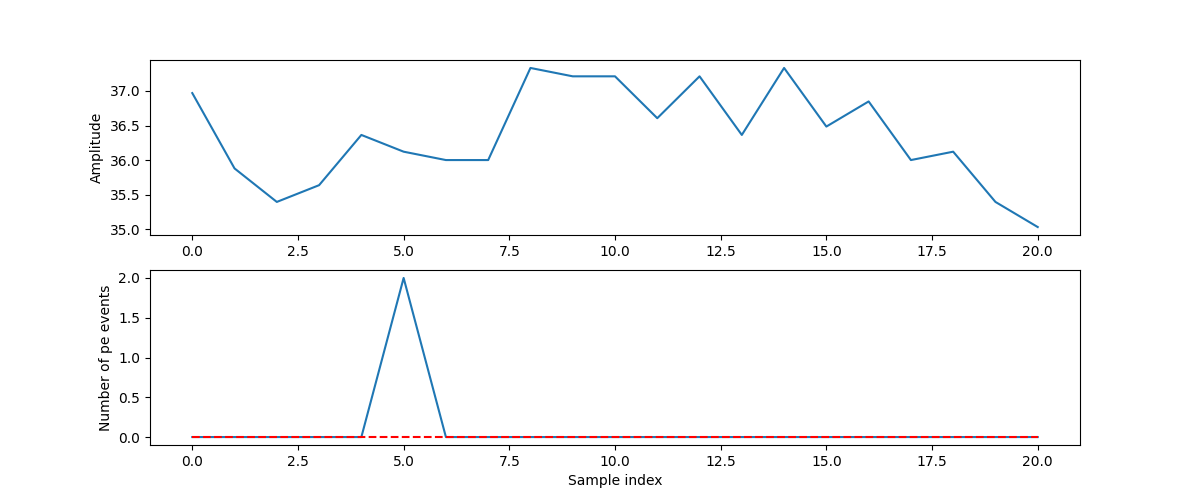

In [49]:
# --------------------------------
# Moving window display
# --------------------------------
i = 564
fig = plt.figure(figsize=(12, 5))

x = np.argwhere(np.sum(val_dataset.truth, axis=1) > 400)
print(f"event where pe > 0 {x}")

def update():
    plt.clf()
    ax1 = plt.subplot(211)
    ax1.plot(val_dataset.data[i], label='Sensor data')
    ax1.set_ylabel('Amplitude')
    ax2 = plt.subplot(212, sharex=ax1)
    # ax2.set_ylim(-2,resultsYMax)
    ax2.set_ylabel('Number of pe events')
    ax2.plot(val_dataset.truth[i], label='Truth')
    # [None, ] is for the batch array dimension, since it's a single event, just add none
    ax2.plot(model.predict(val_dataset.data[i][None,], verbose=0)[0], '--r', label='Prediction')
    plt.xlabel('Sample index')
    plt.draw()

def press(event):
    global i
    # Move window left or right
    if event.key == 'left':
        i-=1
    elif event.key == 'right':
        i+=1
    update()

fig.canvas.mpl_connect('key_press_event', press)
update()
plt.show()